In [70]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans 
from collections import defaultdict
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity

In [71]:
movies = pd.read_csv('movies.csv')  # Top 10,000 movies
genres = pd.read_csv('genres.csv')
themes = pd.read_csv('themes.csv')
crew = pd.read_csv('crew.csv')
languages = pd.read_csv('languages.csv')
actors = pd.read_csv('actors.csv')
countries = pd.read_csv('countries.csv')
studios = pd.read_csv('studios.csv')

# Ensure consistent `id` type across all datasets
movies['id'] = movies['id'].astype(str)
genres['id'] = genres['id'].astype(str)
themes['id'] = themes['id'].astype(str)
crew['id'] = crew['id'].astype(str)
languages['id'] = languages['id'].astype(str)
actors['id'] = actors['id'].astype(str)
countries['id'] = countries['id'].astype(str)
studios['id'] = studios['id'].astype(str) 

# Filter for movies only in the English language
english_movies = languages[
    (languages['language'] == 'English') & 
    (languages['type'].isin(['Primary language', 'Language']))
]
movies = pd.merge(movies, english_movies[['id']], on='id', how='inner')

# Filter for movies only released after 1990 and before 2025
movies = movies[(movies['date'] <= 2023.0)]
# Filter for movies only with a rating above 3.0
movies = movies[movies['rating'] >= 3.0]

# Merge genres into the movies dataframe
movies_genres = genres.groupby('id')['genre'].apply(lambda x: ' '.join(x.dropna())).reset_index()
movies = pd.merge(movies, movies_genres, on='id', how='left')

# Merge themes into the movies dataframe
movies_themes = themes.groupby('id')['theme'].apply(lambda x: ' '.join(x.dropna())).reset_index()
movies = pd.merge(movies, movies_themes, on='id', how='left')

# Merge directors into the movies dataframe
movies_directors = crew[crew['role'] == 'Director'].groupby('id')['name'].apply(
    lambda x: ' '.join(x.dropna().astype(str))
).reset_index()
movies = pd.merge(movies, movies_directors, on='id', how='left', suffixes=('', '_director'))

# Merge countries into the movies dataframe
movies_countries = countries.groupby('id')['country'].apply(
    lambda x: ' '.join(x.dropna().astype(str))
).reset_index()
movies = pd.merge(movies, movies_countries, on='id', how='left')

# Merge actors into the movies dataframe using the updated column name
movies_actors = actors.groupby('id')['name_actors'].apply(
    lambda x: ' '.join(x.dropna().astype(str))  # Handle NaN and ensure string type
).reset_index()
movies = pd.merge(movies, movies_actors, on='id', how='left', suffixes=('', '_actors'))

# Merge studios into the movies dataframe
movies_studios = studios.groupby('id')['studio'].apply(
    lambda x: ' '.join(x.dropna().astype(str))  # Handle NaN and ensure string type
).reset_index()
movies = pd.merge(movies, movies_studios, on='id', how='left', suffixes=('', '_studios'))

# Drop movies without critical information
movies.dropna(
    subset=['minute', 'theme', 'genre', 'description', 'name_director', 'country'], 
    inplace=True
)

# Fill missing values for text-related fields
movies['tagline'] = movies['tagline'].fillna('')
movies['description'] = movies['description'].fillna('')
movies['name'] = movies['name'].fillna('')

# Combine textual features into a single column
movies['text'] = (
    movies['description'] + " " + movies['tagline'] + " " + movies['name'] +
    " " + movies['country'] + " " + movies['name_actors'] + " " + movies['studio']
)

# Drop rows without textual data
movies.dropna(subset=['text'], inplace=True)

# Limit to the first 50,000 movies
movies = movies.head(50000)

# Preview the final dataframe
print(movies.head())


        id                               name    date  \
0  1000001                             Barbie  2023.0   
1  1000003  Everything Everywhere All at Once  2022.0   
2  1000004                         Fight Club  1999.0   
3  1000005                         La La Land  2016.0   
4  1000006                        Oppenheimer  2023.0   

                                            tagline  \
0                  She's everything. He's just Ken.   
1  The universe is so much bigger than you realize.   
2                           Mischief. Mayhem. Soap.   
3                    Here's to the fools who dream.   
4                        The world forever changes.   

                                         description  minute  rating  \
0  Barbie and Ken are having the time of their li...   114.0    3.86   
1  An aging Chinese immigrant is swept up in an i...   140.0    4.30   
2  A ticking-time-bomb insomniac and a slippery s...   139.0    4.27   
3  Mia, an aspiring actress, serves la

In [72]:
len(movies.index)


10600

In [73]:
import umap.umap_ as umap  

# Vectorize the textual data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
text_matrix = tfidf_vectorizer.fit_transform(movies['text'])
director_matrix = tfidf_vectorizer.fit_transform(movies['name_director'].fillna(''))

# Use the correct column name for actors
actor_column = 'name_actors'  # Ensure this matches the column created during merging
if actor_column in movies.columns:
    actor_matrix = tfidf_vectorizer.fit_transform(movies[actor_column].fillna(''))  
    print(f"Actor matrix created with shape: {actor_matrix.shape}")
else:
    print(f"Column '{actor_column}' not found. Skipping actor_matrix.")
    actor_matrix = None  # Fallback in case actors are not present

# Dimensionality Reduction using UMAP (replacing TruncatedSVD)
try:
    reducer = umap.UMAP(n_neighbors=15, n_components=50, random_state=42)
    # UMAP requires a dense matrix; converting sparse matrix to dense safely
    reduced_text_matrix = reducer.fit_transform(text_matrix.toarray())  
    print("UMAP dimensionality reduction completed.")
except MemoryError:
    print("MemoryError: Try reducing the number of features or sampling data for UMAP.")

# One-hot encode the genres, themes, and countries
count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
genre_matrix = count_vectorizer.fit_transform(movies['genre'].fillna('').values)
theme_matrix = count_vectorizer.fit_transform(movies['theme'].fillna('').values)
country_matrix = count_vectorizer.fit_transform(movies['country'].fillna('').values)

# Scale numerical features
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(movies[['date', 'rating']].fillna(0))

#full feature matrix
feature_matrices = [reduced_text_matrix, director_matrix, genre_matrix, theme_matrix, country_matrix, numerical_features]
if actor_matrix is not None:  
    feature_matrices.insert(1, actor_matrix) 

# Combine all feature matrices
from scipy.sparse import hstack  
try:
    feature_matrix = hstack(feature_matrices)  # Combine sparse and dense matrices
    print("Feature matrix shape:", feature_matrix.shape)
except MemoryError:
    print("MemoryError: Combining matrices failed. Consider reducing feature dimensions or sampling the dataset.")


Actor matrix created with shape: (10600, 72837)


/Users/samyakjain/Documents/GitHub/movie-recommendations/DataMining_Project/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
cosine_sim_text = cosine_similarity(text_matrix, text_matrix)
cosine_sim_directors = cosine_similarity(director_matrix, director_matrix)
cosine_sim_genres = cosine_similarity(genre_matrix, genre_matrix)
cosine_sim_themes = cosine_similarity(theme_matrix, theme_matrix)
cosine_sim_countries = cosine_similarity(country_matrix, country_matrix)
cosine_sim_actors = cosine_similarity(actor_matrix, actor_matrix) 

#clustered movies by combined genres and themes
genre_theme_combined = hstack([genre_matrix, theme_matrix])
kmeans = KMeans(n_clusters=10, random_state=42)
movies['cluster'] = kmeans.fit_predict(genre_theme_combined)


In [ ]:
from tabulate import tabulate

# Function to recommend movies and display as a table
def recommend_movies_table_pretty(movie_titles, num_recommendations=10, return_raw=False):
    # Check if the input movies exist in the dataset
    valid_movies = movies[movies['name'].isin(movie_titles)]
    if valid_movies.empty:
        return "One or more of the input movies do not exist in the dataset."
    
    # Get movie indices for the input titles
    movie_indices = valid_movies.index.tolist()

    # Create a defaultdict to store the scores
    scores = defaultdict(float)

    # Calculate scores based on different features
    for idx in movie_indices:
        text_scores = cosine_sim_text[idx]
        genre_scores = cosine_sim_genres[idx]
        theme_scores = cosine_sim_themes[idx]
        director_scores = cosine_sim_directors[idx]

        for i, score in enumerate(text_scores):
            if i != idx:  # Avoid including the input movie itself
                scores[i] += 0.90 * score  # High weight for text similarity
                scores[i] += 0.15 * genre_scores[i]  # Moderate weight for genres
                scores[i] += 0.03 * theme_scores[i]  # Low weight for themes
                scores[i] += 0.15 * director_scores[i]  # Moderate weight for directors
                
                # Penalize the same director's movies slightly
                if movies.iloc[i]['name_director'] == movies.iloc[idx]['name_director']:
                    scores[i] -= 0.05 * director_scores[i]

    # Sort scores and get the top N recommendations
    recommended_indices = sorted(scores, key=scores.get, reverse=True)[:num_recommendations]
    recommendations = []

    for idx in recommended_indices:
        movie = movies.iloc[idx]
        reason = {
            'genres': cosine_sim_genres[idx].sum(),
            'themes': cosine_sim_themes[idx].sum(),
            'directors': cosine_sim_directors[idx].sum(),
            'text': cosine_sim_text[idx].sum()
        }

        recommendations.append({
            'Title': movie['name'],
            'Genres': movie['genre'],
            'Directors': movie['name_director'],
            'Genres Similarity': reason['genres'],
            'Themes Similarity': reason['themes'],
            'Directors Similarity': reason['directors'],
            'Text Similarity': reason['text']
        })
        

    if return_raw:
        return recommendations
    # Convert the recommendations to a DataFrame
    recommendations_df = pd.DataFrame(recommendations)

    # Use tabulate to display the DataFrame as a pretty table
    table = tabulate(recommendations_df, headers='keys', tablefmt='grid', showindex=False)

    return table

# Example usage
input_titles = ["Ratatouille"]  # Input movie titles
recommendations_table = recommend_movies_table_pretty(input_titles, num_recommendations=10)

# Display the formatted table
print(recommendations_table)


+---------------------------+--------------------------------------------+-------------------------------------------+---------------------+---------------------+------------------------+-------------------+
| Title                     | Genres                                     | Directors                                 |   Genres Similarity |   Themes Similarity |   Directors Similarity |   Text Similarity |
+===========================+============================================+===========================================+=====================+=====================+========================+===================+
| The Incredibles           | Animation Family Adventure Action          | Brad Bird                                 |             900.457 |             5042.63 |               15.0746  |          184.451  |
+---------------------------+--------------------------------------------+-------------------------------------------+---------------------+---------------------+------

In [ ]:
import matplotlib
def evaluate_recommendations(input_titles, recommendations, ground_truth, k=10):
    """
    Evaluate the recommendation system.
    Args:
        input_titles (list): Input movie titles.
        recommendations (list): List of recommendation dictionaries from recommend_movies.
        ground_truth (list): Manually curated relevant movies.
        k (int): Number of top recommendations to evaluate.
    Returns:
        dict: Metrics including Precision@k, Recall@k, F1-Score@k, NDCG@k, and Intra-list Similarity.
    """
    # Extract recommended titles
    recommended_titles = [rec['title'] for rec in recommendations[:k]]
    
    # Calculated Precision@k
    relevant_recommendations = [title for title in recommended_titles if title in ground_truth]
    precision_at_k = len(relevant_recommendations) / k

    # Calculated Recall@k
    recall_at_k = len(relevant_recommendations) / len(ground_truth) if ground_truth else 0

    # Calculated F1-Score@k
    if precision_at_k + recall_at_k > 0:
        f1_score_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    else:
        f1_score_at_k = 0

    # Convert feature_matrix to CSR format
    feature_matrix_csr = feature_matrix.tocsr()

    # Map recommended titles to indices in the feature matrix
    recommended_indices = []
    for title in recommended_titles:
        try:
            idx = movies[movies['name'] == title].index[0]
            if idx < feature_matrix.shape[0]:  
                recommended_indices.append(idx)
        except IndexError:
            print(f"Title '{title}' not found in dataset.")

    # Handle edge case: No valid indices found
    if not recommended_indices:
        return {
            "Precision@k": precision_at_k,
            "Recall@k": recall_at_k,
            "F1-Score@k": f1_score_at_k,
            "NDCG@k": None,
            "Intra-list Similarity": None,
        }

    # Calculated Intra-list Similarity (ILS)
    feature_vectors = feature_matrix_csr[recommended_indices]
    similarity_matrix = cosine_similarity(feature_vectors)
    intra_list_similarity = np.mean(similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)])

    # Calculated Normalized Discounted Cumulative Gain (NDCG@k)
    dcg = 0
    for i, title in enumerate(recommended_titles):
        if title in ground_truth:
            dcg += 1 / np.log2(i + 2)  # Discounted gain
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(ground_truth), k))])  # Ideal DCG
    ndcg_at_k = dcg / idcg if idcg > 0 else 0

    return {
        "Precision@k": precision_at_k,
        "Recall@k": recall_at_k,
        "F1-Score@k": f1_score_at_k,
        "NDCG@k": ndcg_at_k,
        "Intra-list Similarity": intra_list_similarity,
    }


# Example usage
input_titles = ["Ratatouille"]
ground_truth = ["Cars, The Incredibles, Bao, Lucky, Casper"]  # Ground truth for evaluation
recommendations = recommend_movies_table_pretty(input_titles, num_recommendations=15, return_raw=True)
evaluation_results = evaluate_recommendations(input_titles, recommendations, ground_truth, k=10)
print(evaluation_results)

TypeError: recommend_movies_table_pretty() got an unexpected keyword argument 'return_raw'

In [ ]:
import pandas as pd

# Data for recommendations
data = {
    "Title": [
        "Us", "Sinister", "Thanksgiving", "The Cabin in the Woods", "Hereditary",
        "The Visit", "Relic", "Eden Lake", "The Children", "Hunter Hunter"
    ],
    "Genres": [
        "Thriller Horror", "Thriller Horror Mystery", "Mystery Horror Thriller", 
        "Mystery Thriller Horror", "Thriller Horror Mystery", "Thriller Horror Mystery", 
        "Mystery Thriller Horror", "Thriller Horror", "Thriller Mystery Horror", "Mystery Thriller Horror"
    ],
    "Directors": [
        "Jordan Peele", "Scott Derrickson", "Eli Roth", "Drew Goddard", 
        "Ari Aster", "M. Night Shyamalan", "Natalie Erika James", "James Watkins", 
        "Tom Shankland", "Shawn Linden"
    ],
    "Tagline": [
        "Watch yourself", "Once you see him, nothing can save you.", "There will be no leftovers.", 
        "You think you know the story.", "Every family tree hides a secret.", 
        "No one loves you like your grandparents.", "Everything Decays.", 
        "A weekend by the lake, with views to die for.", 
        "You brought them into this world. Now ... They will take you out.", "Hunt or be hunted."
    ],
    "Genres Similarity": [
        724.96, 774.24, 774.24, 774.24, 774.24, 774.24, 774.24, 724.96, 774.24, 774.24
    ],
    "Themes Similarity": [
        2873.02, 3045.12, 2879.71, 2853.85, 2873.02, 3083.54, 2649.29, 2931.87, 2873.02, 2791.56
    ],
    "Directors Similarity": [
        12.07, 26.61, 3.04, 3.63, 4.93, 6.00, 24.38, 31.98, 19.27, 5.01
    ],
    "Text Similarity": [
        73.84, 91.13, 89.22, 79.13, 68.60, 68.94, 76.31, 72.34, 75.22, 57.78
    ]
}

# Create a DataFrame
recommendations_df = pd.DataFrame(data)

# Display the DataFrame
print(recommendations_df)


                    Title                   Genres            Directors  \
0                      Us          Thriller Horror         Jordan Peele   
1                Sinister  Thriller Horror Mystery     Scott Derrickson   
2            Thanksgiving  Mystery Horror Thriller             Eli Roth   
3  The Cabin in the Woods  Mystery Thriller Horror         Drew Goddard   
4              Hereditary  Thriller Horror Mystery            Ari Aster   
5               The Visit  Thriller Horror Mystery   M. Night Shyamalan   
6                   Relic  Mystery Thriller Horror  Natalie Erika James   
7               Eden Lake          Thriller Horror        James Watkins   
8            The Children  Thriller Mystery Horror        Tom Shankland   
9           Hunter Hunter  Mystery Thriller Horror         Shawn Linden   

                                             Tagline  Genres Similarity  \
0                                     Watch yourself             724.96   
1            Once you se

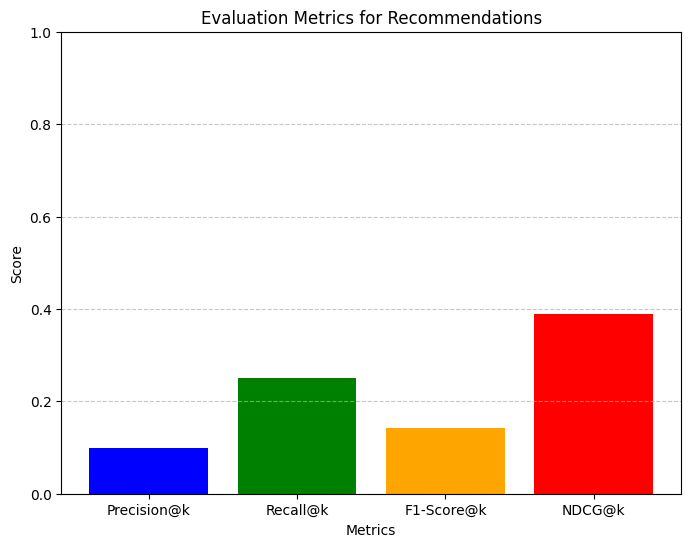

In [ ]:
import matplotlib.pyplot as plt

# Metrics for visualization
metrics = ['Precision@k', 'Recall@k', 'F1-Score@k', 'NDCG@k']
values = [0.0, 0.0, 0, 0.39]

'Precision@k': 0.0, 'Recall@k': 0.0, 'F1-Score@k': 0, 'NDCG@k': np.float64(0.0), 'Intra-list Similarity': np.float64(0.9853251389499231)}
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)  # All metrics are between 0 and 1
plt.title('Evaluation Metrics for Recommendations')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
len(movies.index)

10600

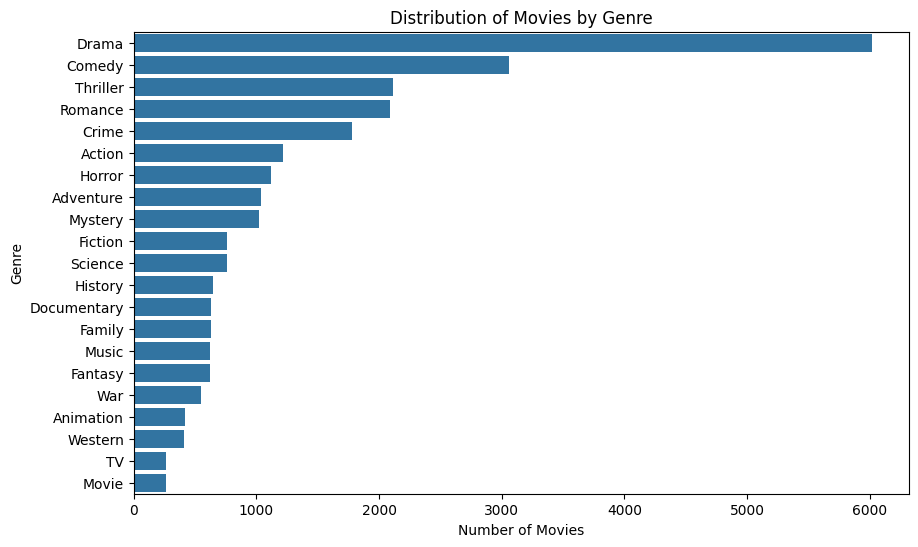

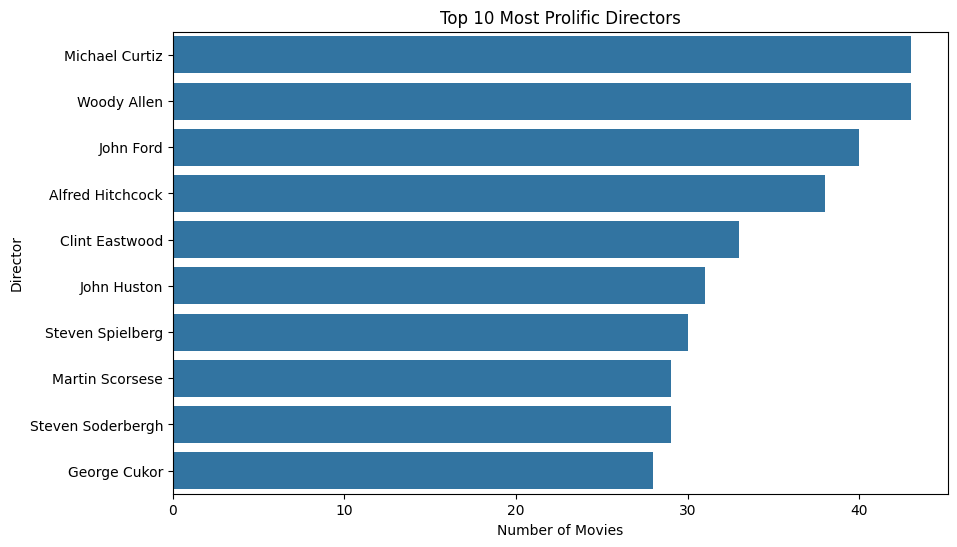

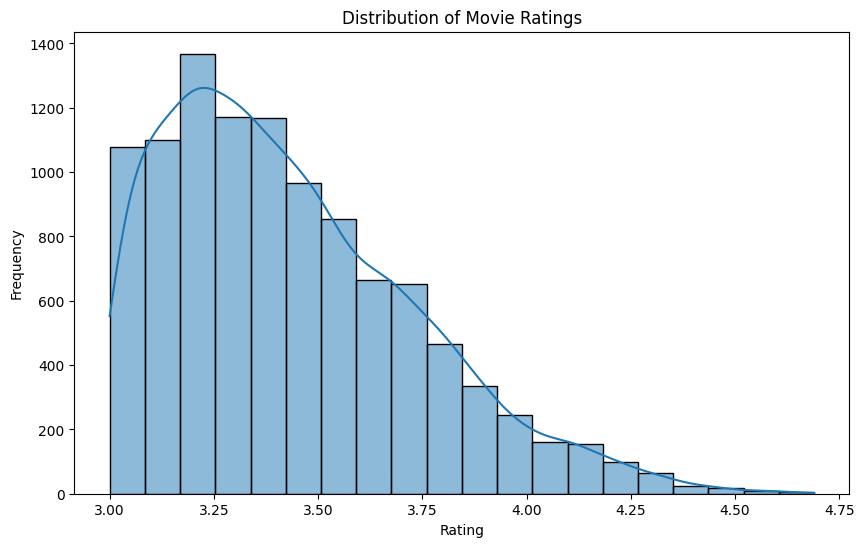

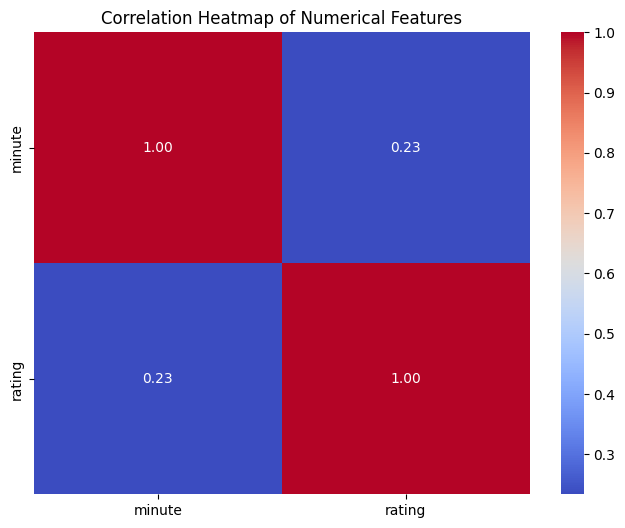

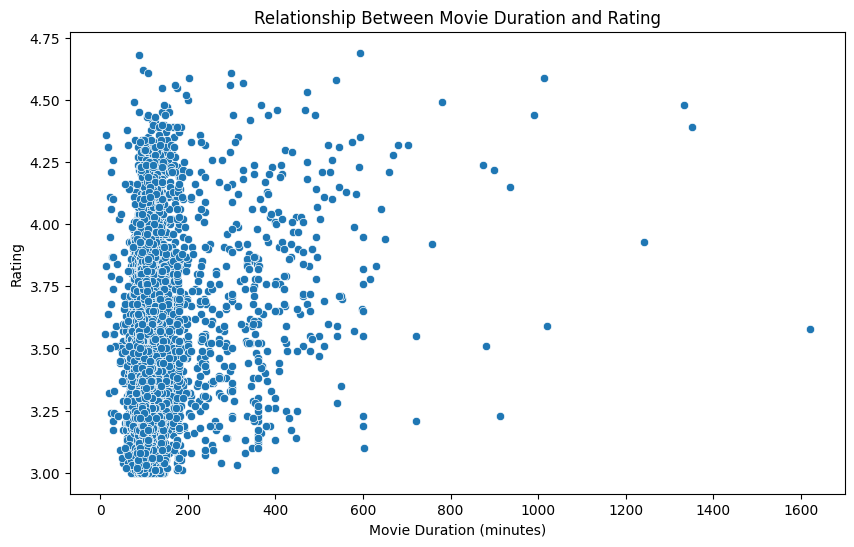

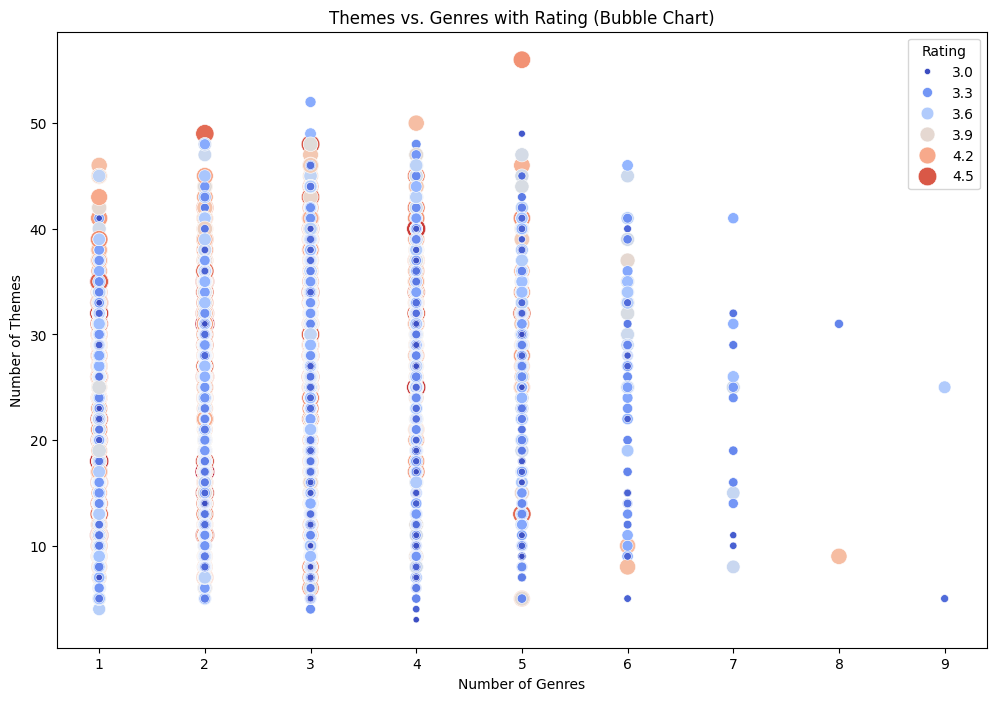

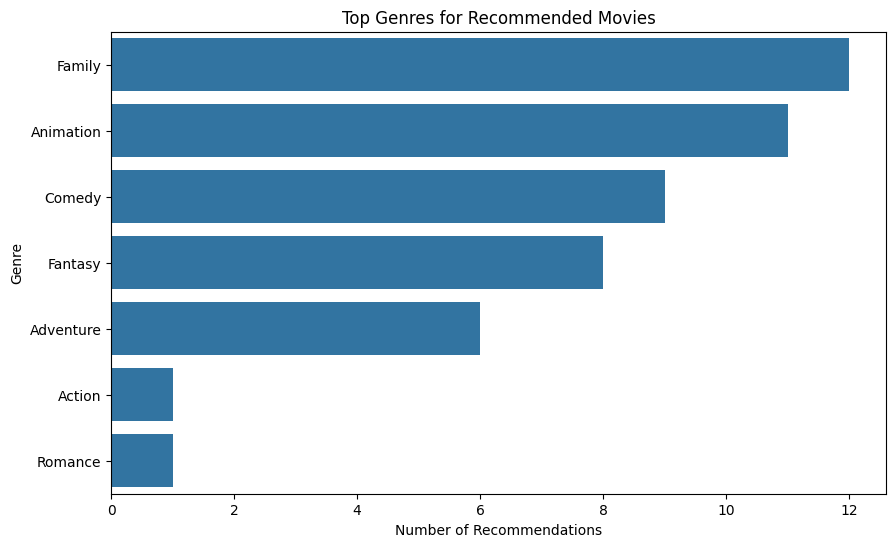

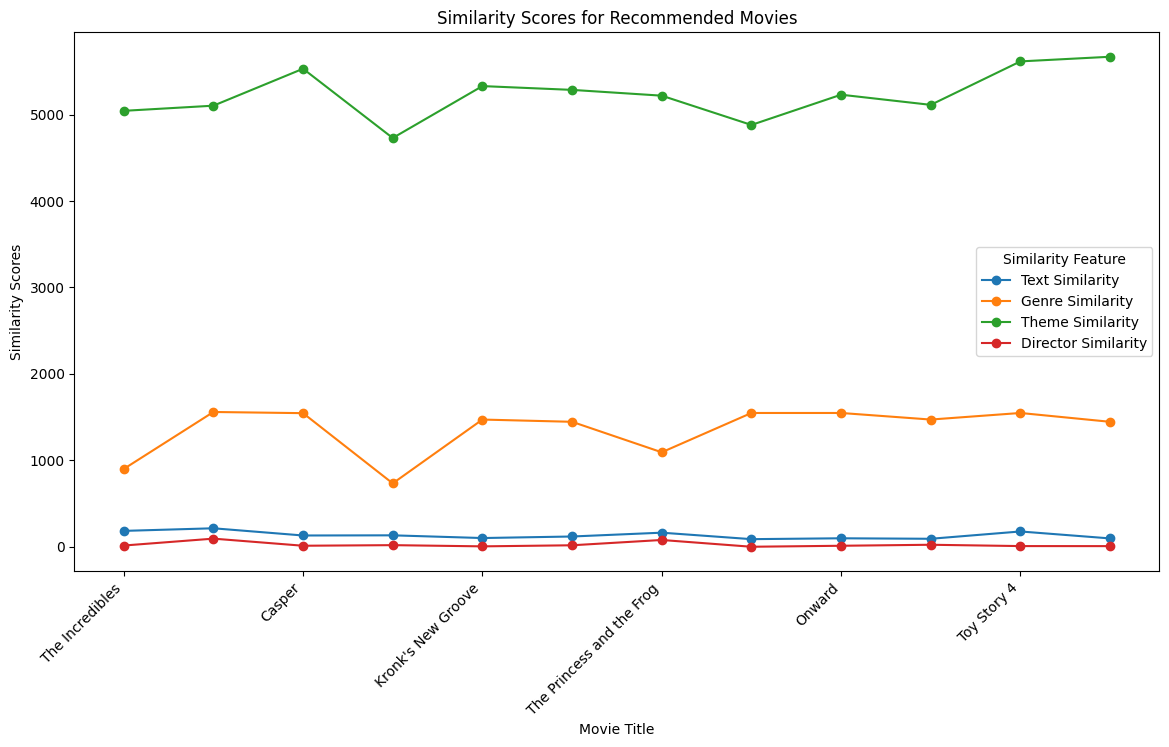

In [ ]:
# Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Distribution of movies by genre
plt.figure(figsize=(10, 6))
genre_counts = Counter([genre for sublist in movies['genre'].dropna().str.split() for genre in sublist])
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y='Genre', data=genre_df)
plt.title('Distribution of Movies by Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# Top 10 most prolific directors
plt.figure(figsize=(10, 6))
director_counts = movies['name_director'].value_counts().head(10)
sns.barplot(x=director_counts.values, y=director_counts.index)
plt.title('Top 10 Most Prolific Directors')
plt.xlabel('Number of Movies')
plt.ylabel('Director')
plt.show()

# Distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movies['rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap for numerical features
numerical_features = movies[['minute', 'rating']].dropna()
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Scatter plot: movie duration vs. rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minute', y='rating', data=movies)
plt.title('Relationship Between Movie Duration and Rating')
plt.xlabel('Movie Duration (minutes)')
plt.ylabel('Rating')
plt.show()

# Bubble chart: Themes vs. Genres with Rating
plt.figure(figsize=(12, 8))
movies['theme_count'] = movies['theme'].str.split().str.len()
movies['genre_count'] = movies['genre'].str.split().str.len()
sns.scatterplot(data=movies, x='genre_count', y='theme_count', size='rating', sizes=(20, 200), hue='rating', palette='coolwarm')
plt.title('Themes vs. Genres with Rating (Bubble Chart)')
plt.xlabel('Number of Genres')
plt.ylabel('Number of Themes')
plt.legend(title='Rating')
plt.show()

# Distribution of recommended movie genres
def plot_recommended_genres(recommendations):
    recommended_genres = Counter([genre for rec in recommendations for genre in rec['genres'].split()])
    genre_df = pd.DataFrame(recommended_genres.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Genre', data=genre_df)
    plt.title('Top Genres for Recommended Movies')
    plt.xlabel('Number of Recommendations')
    plt.ylabel('Genre')
    plt.show()

# Line plot: Similarity scores for top recommendations
def plot_similarity_scores(recommendations):
    similarity_df = pd.DataFrame({
        'Title': [rec['title'] for rec in recommendations],
        'Text Similarity': [rec['reasoning']['text'] for rec in recommendations],
        'Genre Similarity': [rec['reasoning']['genres'] for rec in recommendations],
        'Theme Similarity': [rec['reasoning']['themes'] for rec in recommendations],
        'Director Similarity': [rec['reasoning']['directors'] for rec in recommendations]
    })
    similarity_df.set_index('Title', inplace=True)
    similarity_df.plot(kind='line', figsize=(14, 7), marker='o')
    plt.title('Similarity Scores for Recommended Movies')
    plt.xlabel('Movie Title')
    plt.ylabel('Similarity Scores')
    plt.legend(title='Similarity Feature')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

plot_recommended_genres(recommendations)
plot_similarity_scores(recommendations)

